# Analysis of Real Data from the PDHD Detector

Once you're comfortable with the simplified MC data, the next step is to analyze real data collected by the ProtoDUNE Horizontal Drift (PDHD) detector. 
**This notebook focuses on the run 32974, TPC=2, event=32, collection plane.**

As a surface detector, PDHD is continuously bombarded by cosmic rays, resulting in multiple overlapping tracks within each recorded event. For these data dead channels (overactivity with no real physical signal) have already been masked.

In [2]:
import uproot #Uproot is a Python library that allows you to read, write, and manipulate ROOT files without requiring ROOT or C++.
import awkward as ak #this is for ragged data handling, which is common in particle physics data
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings
# %matplotlib widget 
warnings.filterwarnings('ignore') # Ignore warnings for cleaner output

filepath = "../data/pdhd_run032974_tps.root"    

with uproot.open(filepath) as file:
    tree = file["triggerana/tree"]  # Adjust the path if your tree is elsewhere
    print(tree.keys())  # This prints all branch names in the tree

['event', 'run', 'subrun', 'TP_channel', 'TP_startT', 'TP_peakT', 'TP_TOT', 'TP_SADC', 'TP_peakADC', 'TP_plane', 'TP_TPC']


In [3]:
#instead of using all the branches, we can specify which ones we want to read
def load_data(filepath, branch_names, max_events=3000):
    """Load data from a ROOT file into a pandas DataFrame."""
    try:
        with uproot.open(filepath) as file:
            tree = file["triggerana/tree"]
            arrays = tree.arrays(branch_names, library="ak", entry_stop=max_events)
            return ak.to_dataframe(arrays)
    except Exception as e:
        print(f"Error loading data from {filepath}: {e}")
        return None

# name of branches in the TTree to read into the pandas df
TP_BRANCHES_df = ['event', 'run', 'subrun', 'TP_channel', 'TP_startT', 'TP_peakT', 'TP_TOT', 'TP_SADC', 'TP_peakADC', 'TP_plane', 'TP_TPC'] #trigger primitives for real data

In [4]:
#Let's load the data from runs
df_32974= load_data(filepath, TP_BRANCHES_df, 10000)
df_32974.run_name = "Cosmic run 32974"

In [5]:
#Let's see what event IDs exist in the file
triggers = df_32974.event.unique()
print(f"Event {triggers}")

Event [  8  16  24  32  40  48  56  64  72  80  88  96 104 112 120 128 136 144
 152 160 168 176 184 192 200 208 216 224 232 240 248 256 264 272 280 288
 296 304 360 368]


In [6]:
# Global variable for APA ranges
apa_ranges = {
    "APA1": (0, 2560),
    "APA3": (2560, 5120),
    "APA2": (5120, 7680),
    "APA4": (7680, 10240),
}

In [7]:
event=56
plane=2
TPC=2

def make_title(run, event, TPC, plane, cuts="no cuts"):
    return f"Run {run} | Event {event} | TPC {TPC} | Plane {plane} | {cuts}"

### Characteristics of a single run, single event, collection plane hits of a single TPC. 

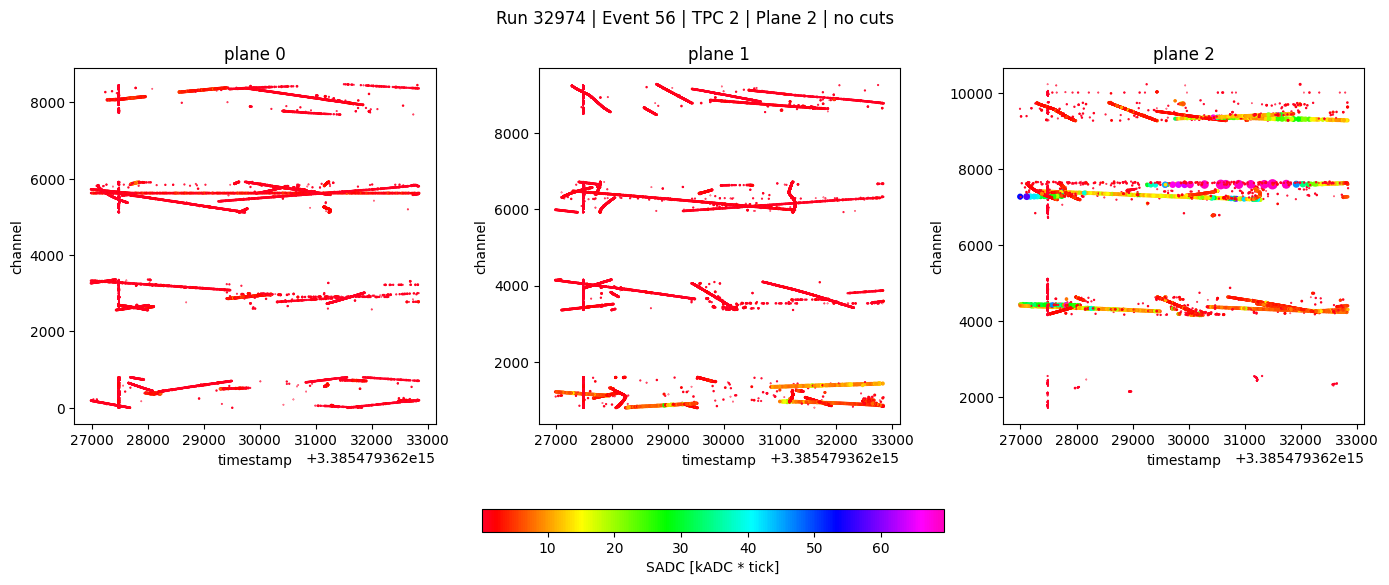

In [8]:
#timestamps correspond to microseconds, the big number is the first detection hit in timestamp
# Note: APA1 collection plane is broken so we will not use it in this analysis.

tps_32974 = df_32974[(df_32974.event == event)]
tps_32974.run_name = "Cosmic run 32974"
vmin, vmax = tps_32974["TP_SADC"].min()/1e3, (tps_32974["TP_SADC"].max()/1e3)/2
fig, ax = plt.subplots(1, 3, figsize=(14, 6))

for plane in range(3):
    tps = tps_32974[tps_32974.TP_plane == plane]
    sc = ax[plane].scatter(tps.TP_peakT, tps.TP_channel, s=tps.TP_TOT / 10, c=tps.TP_SADC/1e3, cmap='gist_rainbow', vmin=vmin, vmax=vmax)
    ax[plane].set_xlabel("timestamp")
    ax[plane].set_ylabel("channel")
    ax[plane].set_title(f"plane {plane}")   
    
plt.suptitle(make_title(tps['run'].unique()[0], event, TPC, plane))
fig.colorbar(sc, ax=ax, orientation='horizontal', fraction=0.05, pad=-0.3).set_label("SADC [kADC * tick]")
plt.tight_layout()
plt.show()

- Induction planes appear to be noisier and have less SADC variations.
- Increased noise due to pile-up of simultaneous activity.
- More variable noise levels compared to MC simulations, and noisy/dead channels (which can change across multiple trigger records, as the data taking conditions are never exactly the same!)

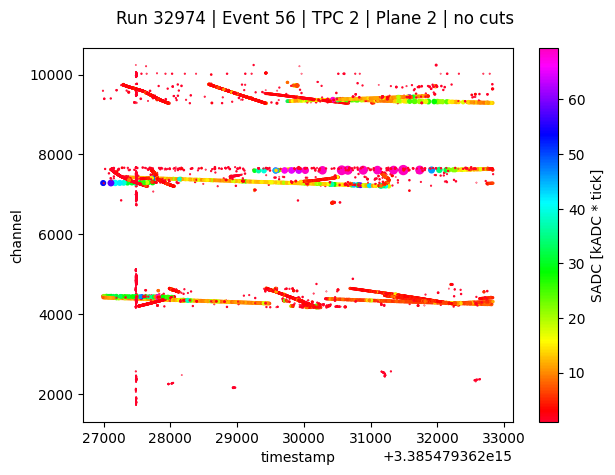

In [9]:
vmin, vmax = 1, (tps_32974["TP_SADC"].max()/1e3)/2
plt.figure()

tps = tps_32974[tps_32974.TP_plane == plane]
tps.run_name = "Cosmic run 32974"
sc = plt.scatter(tps.TP_peakT, tps.TP_channel, s=tps.TP_TOT / 10, c=tps.TP_SADC/1e3, cmap='gist_rainbow', vmin=vmin, vmax=vmax)
plt.xlabel("timestamp")
plt.ylabel("channel")

plt.suptitle(make_title(tps['run'].unique()[0], event, TPC, plane))
cbar = plt.colorbar(sc)
cbar.set_label("SADC [kADC * tick]")
plt.tight_layout()
plt.show()

In [10]:
print(f"TP_SADC: Minimum value {tps['TP_SADC'].min()/1e3}, maximum {(tps['TP_SADC'].max()/1e3)}, mean {tps['TP_SADC'].mean()/1e3}, std deviation {tps['TP_SADC'].std()/1e3}")
print(f"TP_PeakADC: Minimum value {tps['TP_peakADC'].min()}, maximum {(tps['TP_peakADC'].max())}, mean {tps['TP_peakADC'].mean()}, std deviation {tps['TP_peakADC'].std()}")
print(f"TP_TOT: Minimum value {tps['TP_TOT'].min()}, maximum {(tps['TP_TOT'].max())}, mean {tps['TP_TOT'].mean()}, std deviation {tps['TP_TOT'].std()}")


TP_SADC: Minimum value 0.061, maximum 138.8, mean 4.02704966425947, std deviation 6.5962281779196665
TP_PeakADC: Minimum value 61, maximum 3875, mean 372.8781198530343, std deviation 281.2000937872943
TP_TOT: Minimum value 1, maximum 414, mean 13.710756366400608, std deviation 15.949913116750578


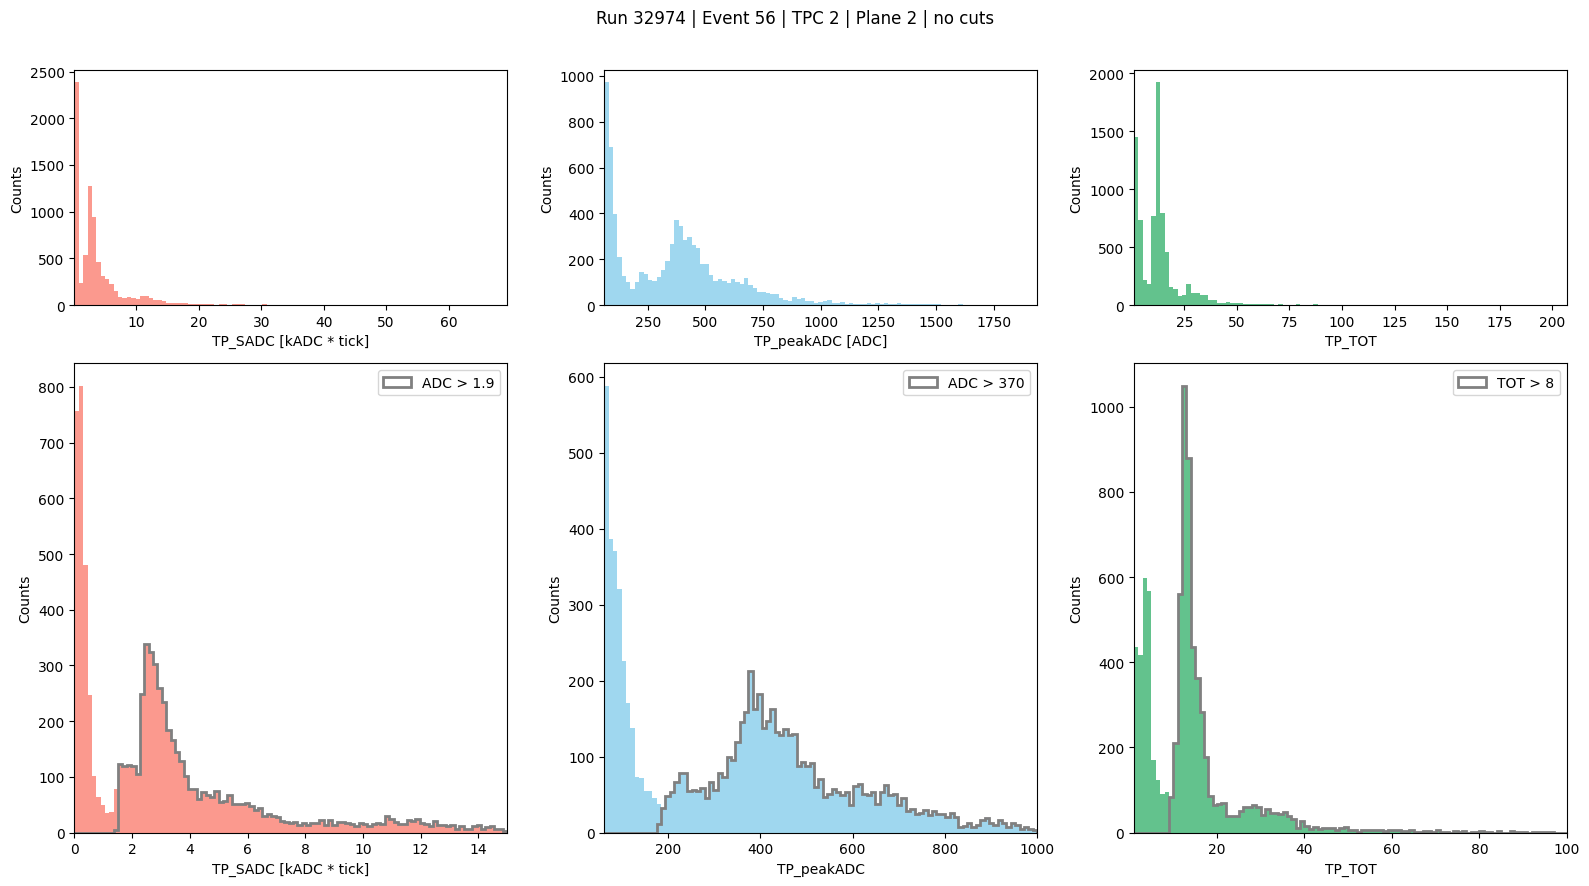

In [11]:
fig, axs = plt.subplots(2, 3, figsize=(16, 9), gridspec_kw={'height_ratios': [1, 2]})

plt.suptitle(make_title(tps['run'].unique()[0], event, TPC, plane))

# 1. TP_SADC
bins_sadc = np.linspace(tps['TP_SADC'].min()/1e3, tps['TP_SADC'].max()/2e3, 100)
axs[0, 0].hist(tps['TP_SADC']/1e3, bins=bins_sadc, alpha=0.8, color='salmon')
axs[0, 0].set_xlabel('TP_SADC [kADC * tick]')
axs[0, 0].set_ylabel('Counts')
axs[0, 0].set_xlim(bins_sadc[0], bins_sadc[-1])

mask_sadc = (tps['TP_SADC']/1e3 >= 0) & (tps['TP_SADC']/1e3 <= 15)
tps_zoom_sadc = tps[mask_sadc]
bins_sadc_zoom = np.linspace(0, 15, 100)
axs[1, 0].hist(tps_zoom_sadc['TP_SADC']/1e3, bins=bins_sadc_zoom, alpha=0.8, color='salmon')
axs[1, 0].set_xlabel('TP_SADC [kADC * tick]')
axs[1, 0].set_ylabel('Counts')
axs[1, 0].set_xlim(bins_sadc_zoom[0], bins_sadc_zoom[-1])

threshold_sadc = 1.5
sadc_cut = tps_zoom_sadc[tps_zoom_sadc['TP_SADC']/1e3 > threshold_sadc]
axs[1, 0].hist(sadc_cut['TP_SADC']/1e3, bins=bins_sadc_zoom, histtype='step', color='gray', linewidth=2, label='ADC > 1.9')
axs[1, 0].legend()

# 2. TP_peakADC
bins_adc = np.linspace(tps['TP_peakADC'].min(), tps['TP_peakADC'].max()/2, 100)
axs[0, 1].hist(tps['TP_peakADC'], bins=bins_adc, alpha=0.8, color='skyblue')
axs[0, 1].set_xlabel('TP_peakADC [ADC]')
axs[0, 1].set_ylabel('Counts')
axs[0, 1].set_xlim(bins_adc[0], bins_adc[-1])

mask_adc = (tps['TP_peakADC'] >= 61) & (tps['TP_peakADC'] <= 1000)
tps_zoom_adc = tps[mask_adc]
bins_adc_zoom = np.linspace(61, 1000, 100)
axs[1, 1].hist(tps_zoom_adc['TP_peakADC'], bins=bins_adc_zoom, alpha=0.8, color='skyblue')
axs[1, 1].set_xlabel('TP_peakADC')
axs[1, 1].set_ylabel('Counts')
axs[1, 1].set_xlim(bins_adc_zoom[0], bins_adc_zoom[-1])

threshold_adc = 180
adc_cut = tps_zoom_adc[tps_zoom_adc['TP_peakADC'] > threshold_adc]
axs[1, 1].hist(adc_cut['TP_peakADC'], bins=bins_adc_zoom, histtype='step', color='gray', linewidth=2, label='ADC > 370')
axs[1, 1].legend()

# 3. TP_TOT
bins_tot = np.linspace(tps['TP_TOT'].min(), tps['TP_TOT'].max()/2, 100)
axs[0, 2].hist(tps['TP_TOT'], bins=bins_tot, alpha=0.8, color='mediumseagreen')
axs[0, 2].set_xlabel('TP_TOT')
axs[0, 2].set_ylabel('Counts')
axs[0, 2].set_xlim(bins_tot[0], bins_tot[-1])

mask_tot = (tps['TP_TOT'] >= 1) & (tps['TP_TOT'] <= 100)
tps_zoom_tot = tps[mask_tot]
bins_tot_zoom = np.linspace(1, 100, 100)
axs[1, 2].hist(tps_zoom_tot['TP_TOT'], bins=bins_tot_zoom, alpha=0.8, color='mediumseagreen')
axs[1, 2].set_xlabel('TP_TOT')
axs[1, 2].set_ylabel('Counts')
axs[1, 2].set_xlim(bins_tot_zoom[0], bins_tot_zoom[-1])

threshold_tot = 8
tot_cut = tps_zoom_tot[tps_zoom_tot['TP_TOT'] > threshold_tot]
axs[1, 2].hist(tot_cut['TP_TOT'], bins=bins_tot_zoom, histtype='step', color='gray', linewidth=2, label='TOT > 8')
axs[1, 2].legend()

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

- Clearly a presence of peak at lower energy and lower thresholds (noisier data)

    The small bump is connected to the actual presence of MIP

- The noise we are seeing i the small contribution of natural radioactivity of Liquid Argon 39

Total time for event: 5847 ticks, 2.9235 s
Number of unique timestamps: 3611  of duration 500 ns
Mean duration between timestamps: 1.6196675900277009
Std deviation of durations: 1.3421365941758865
Min duration: 1
Max duration: 19


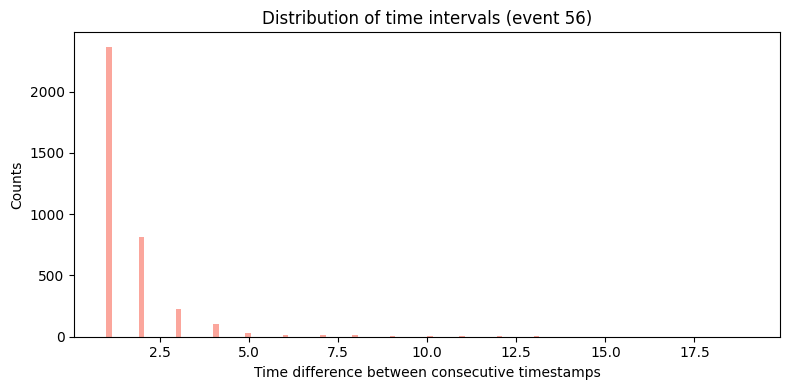

In [12]:
total_time = tps["TP_peakT"].max() - tps["TP_peakT"].min()
print(f"Total time for event: {total_time} ticks, {total_time*500/1e6} s") #ticks occur every 500 ns
num_timestamps = tps["TP_peakT"].nunique()
print("Number of unique timestamps:", num_timestamps, " of duration 500 ns")  #During event reconstruction and data storage, the same timestamp (tick value) is assigned to all channels/wires for that sampling instant.

# Time differences between consecutive timestamps
sorted_timestamps = np.sort(tps["TP_peakT"].unique())
time_diffs = np.diff(sorted_timestamps)
print("Mean duration between timestamps:", np.mean(time_diffs))
print("Std deviation of durations:", np.std(time_diffs))
print("Min duration:", np.min(time_diffs))
print("Max duration:", np.max(time_diffs))

plt.figure(figsize=(8,4))
plt.hist(time_diffs, bins=int(2*np.sqrt(len(time_diffs))), color='salmon', alpha=0.7)
plt.xlabel("Time difference between consecutive timestamps")
plt.ylabel("Counts")
plt.title("Distribution of time intervals (event {})".format(event))
plt.tight_layout()
plt.show()



- The readout is the ADC counts as a function of ticks, 500 ns on each channel. Each event spans 3s circa.  


- Many ticks have no new hit occuring (no threshold crossing). As a result the difference time between time stamps is differentS

### Looking into thresholds and noise removal

Threshold (TP_SADC): 1.5 (TPs: 5245, Retaining 66.45% of raw TP)


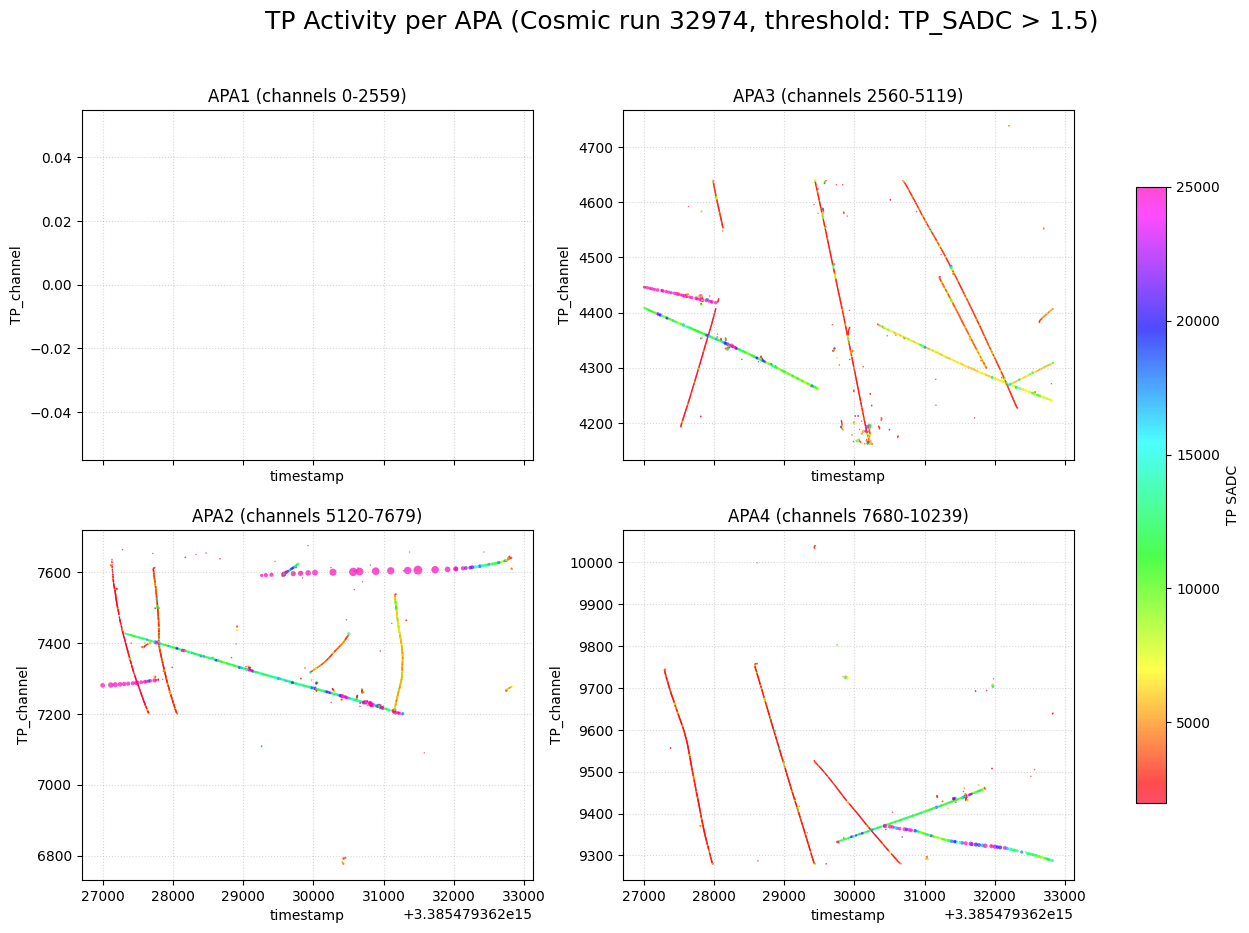

Threshold (TP_peakADC): 180 (TPs: 5366, Retaining 67.98% of raw TP)


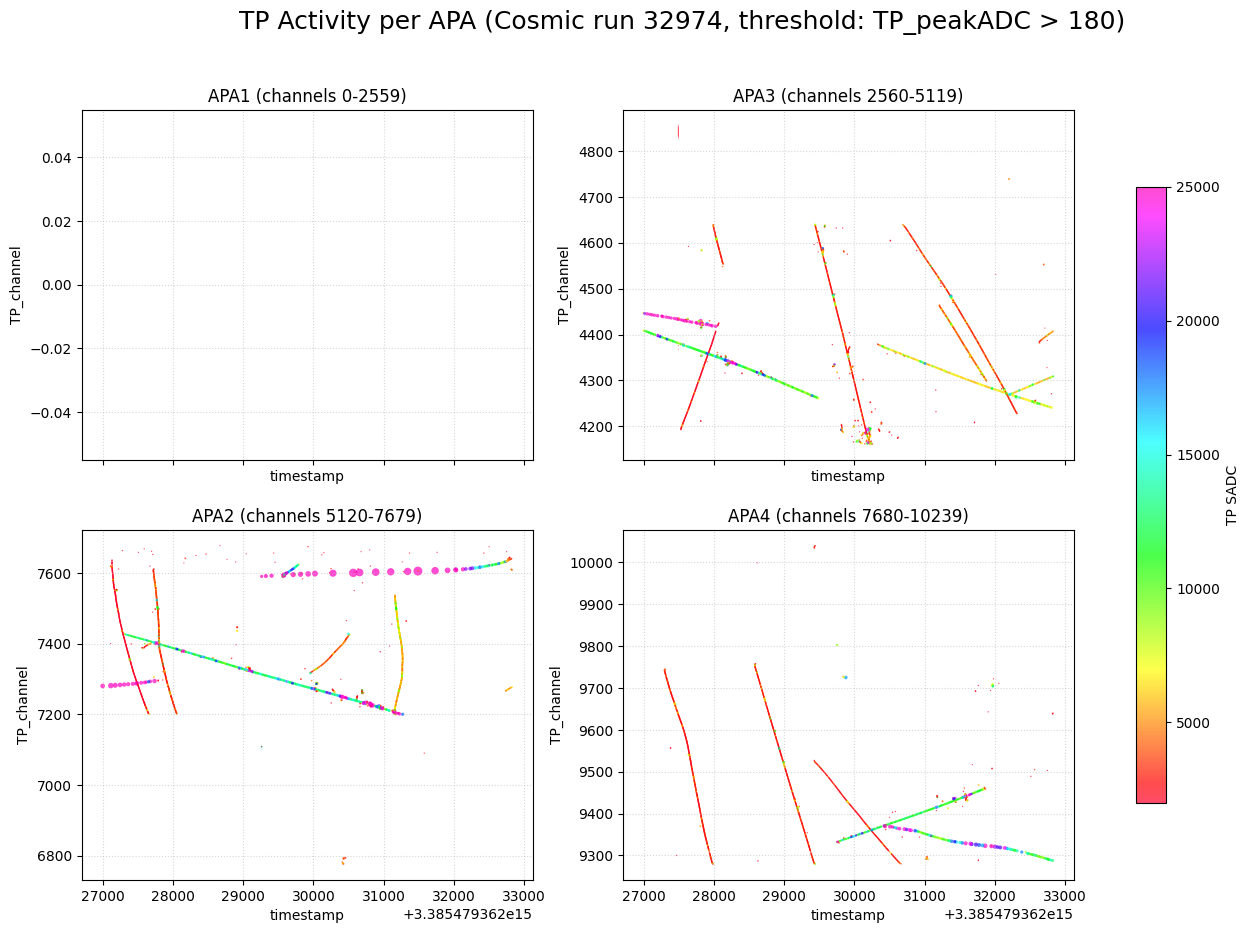

Threshold (TP_TOT): 8 (TPs: 5396, Retaining 68.36% of raw TP)


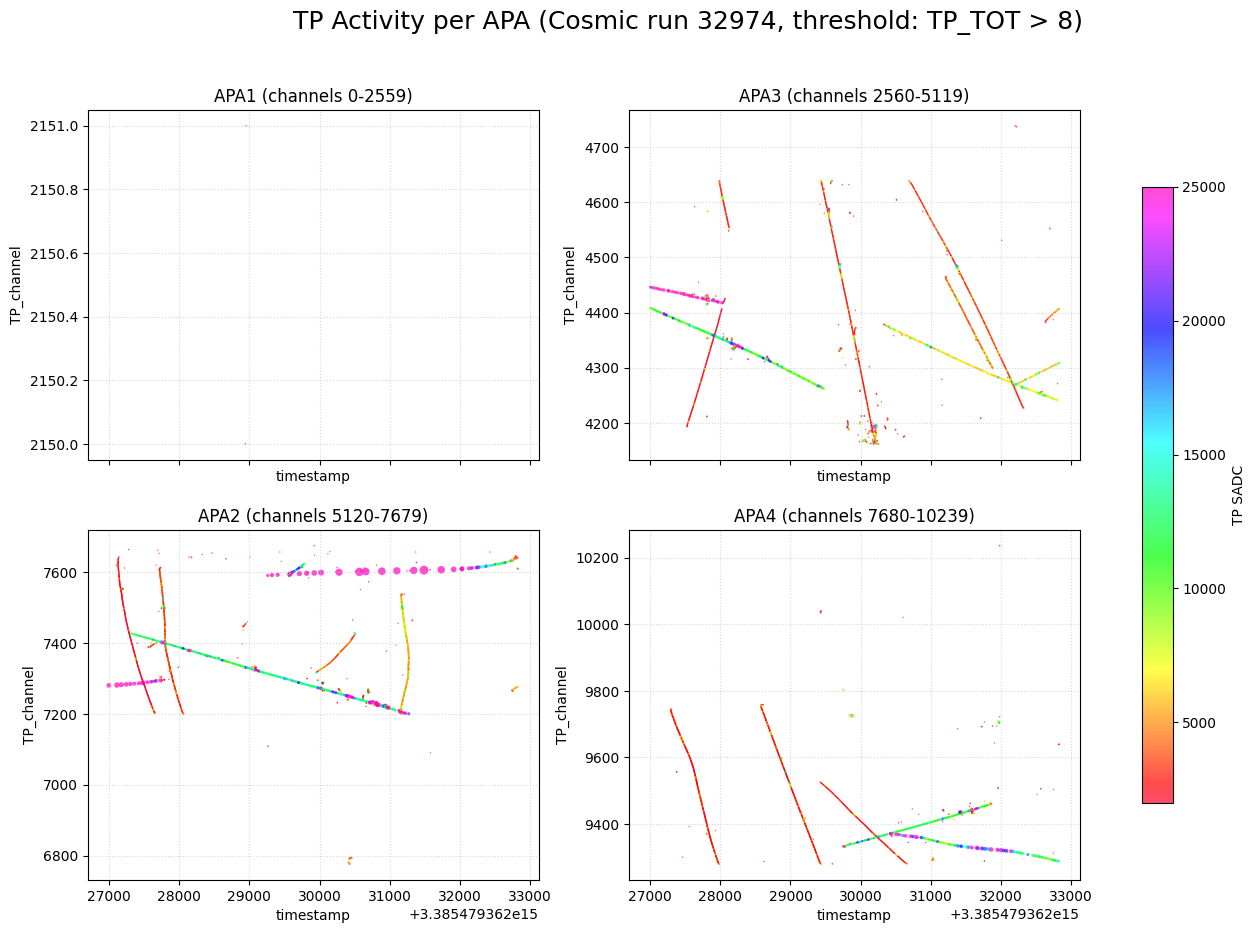

In [13]:
def plot_TPC_activity(tp_df, thresh, thresh_type="TP_peakADC", vmin=None, vmax=None, show_counts=True):
    global apa_ranges 
    title_prefix = "TP Activity per APA"
    # Filter based on the threshold type
    if thresh_type == "TP_peakADC":
        filtered = tp_df[tp_df.TP_peakADC > thresh]
    elif thresh_type == "TP_TOT":
        filtered = tp_df[tp_df.TP_TOT > thresh]
    elif thresh_type == "TP_SADC":
        filtered = tp_df[tp_df.TP_SADC / 1e3 > thresh]
    else:
        raise ValueError(f"Unknown threshold type: {thresh_type}")

    print(f"Threshold ({thresh_type}): {thresh} (TPs: {len(filtered)}, Retaining {len(filtered)/len(tp_df)*100:.2f}% of raw TP)")
    run_type = tp_df.run_name if hasattr(tp_df, 'run_name') else "unknown_run"
    plot_title = f"{title_prefix} ({run_type}, threshold: {thresh_type} > {thresh})"

    # --- Scatter plots ---
    fig, axs = plt.subplots(2, 2, figsize=(16, 10), sharex=True)
    for i, (apa, (start, stop)) in enumerate(apa_ranges.items()):
        ax = axs[i//2][i%2]
        df_apa = filtered[(filtered.TP_channel >= start) & (filtered.TP_channel < stop)]
        sc = ax.scatter(
            df_apa.TP_peakT, df_apa.TP_channel,
            s=df_apa.TP_TOT / 10,
            c=df_apa.TP_SADC,
            cmap="gist_rainbow",
            alpha=0.7,
            edgecolor="none",
            vmin=vmin, vmax=vmax
        )
        ax.set_title(f"{apa} (channels {start}-{stop-1})")
        ax.set_xlabel("timestamp")
        ax.set_ylabel("TP_channel")
        ax.grid(True, linestyle="dotted", alpha=0.5)

    plt.suptitle(f"{plot_title}", fontsize=18)
    fig.colorbar(sc, ax=axs, orientation="vertical", shrink=0.8, label="TP SADC")
    plt.show()

    # --- Bar plot: TP count per APA ---
    if show_counts:
        apa_counts = [
            len(filtered[(filtered.TP_channel >= start) & (filtered.TP_channel < stop)])
            for (start, stop) in apa_ranges.values()
        ]
        plt.figure(figsize=(8, 5))
        plt.bar(apa_ranges.keys(), apa_counts, color='steelblue')
        plt.ylabel("Number of TPs")
        plt.title(f"Total TP Count per APA ({thresh_type} > {thresh})")
        plt.show()

# For SADC threshold
plot_TPC_activity(tps, threshold_sadc, 
            vmin=2000, vmax=25000, thresh_type="TP_SADC", show_counts=False)

# For ADC threshold
plot_TPC_activity(tps, threshold_adc, 
            vmin=2000, vmax=25000, thresh_type="TP_peakADC", show_counts=False)

# For TOT threshold
plot_TPC_activity(tps, threshold_tot, 
            vmin=2000, vmax=25000, thresh_type="TP_TOT", show_counts=False)

### Spatial distribution

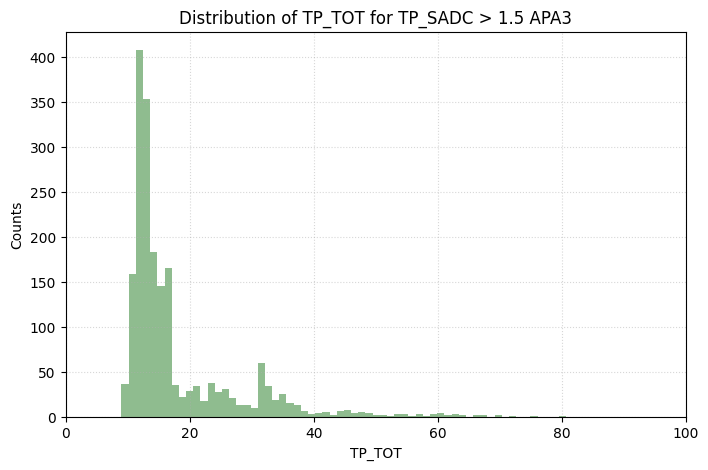

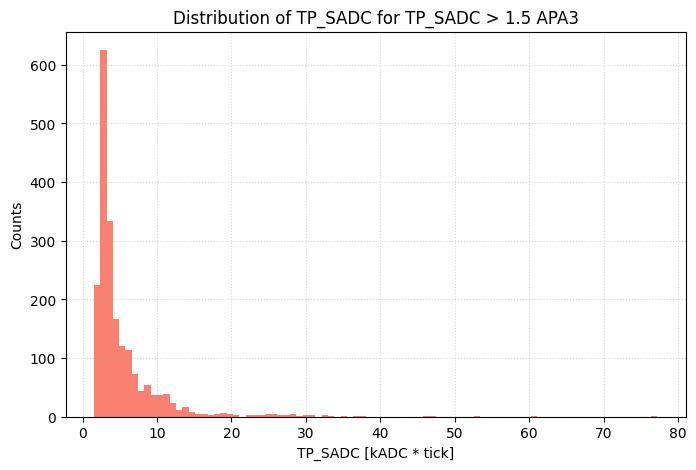

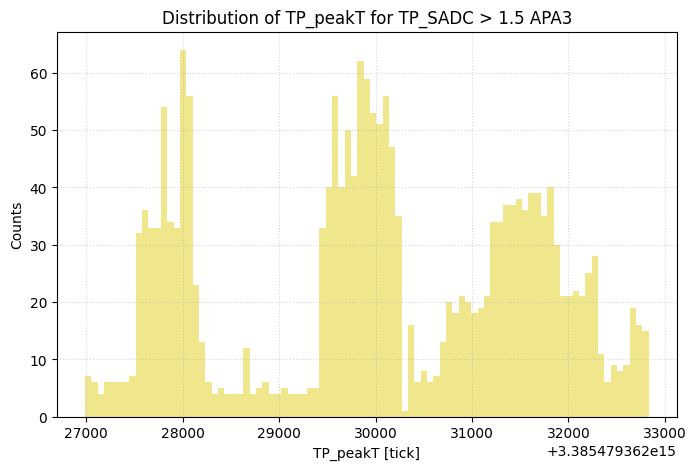

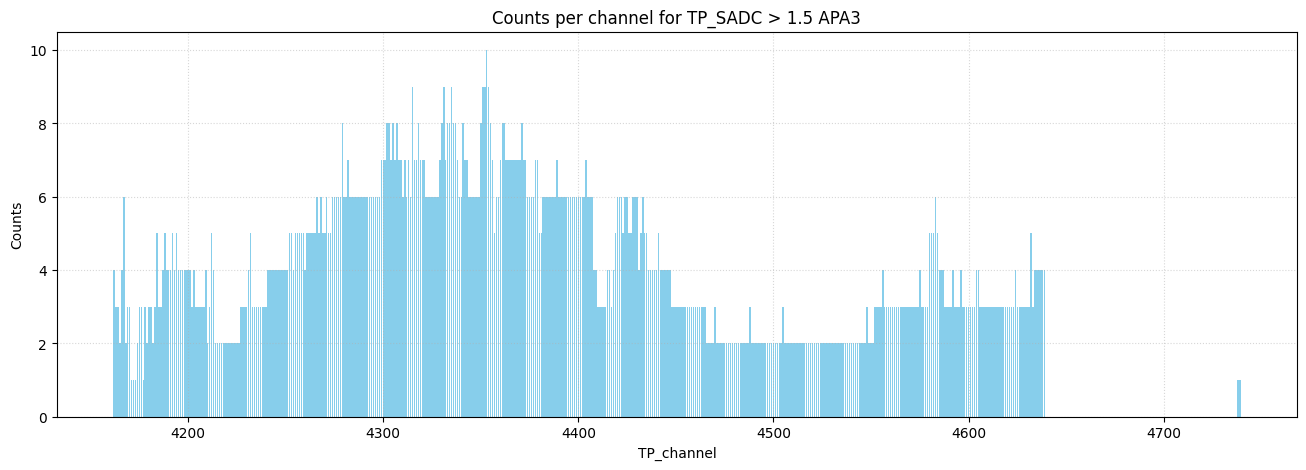

In [67]:
filtered_tps= tps[tps.TP_SADC / 1e3 > threshold_sadc]
filtered_APA3=filtered_tps[(filtered_tps.TP_channel>=apa_ranges["APA3"][0]) & (filtered_tps.TP_channel<apa_ranges["APA3"][1])]

# Plot TP_TOT distribution for filtered data by SADC threshold
plt.figure(figsize=(8,5))
plt.hist(filtered_APA3.TP_TOT, bins=int(2*np.sqrt(len(filtered_APA3))), color='darkseagreen')
plt.xlabel("TP_TOT")
plt.ylabel("Counts")
plt.title(f"Distribution of TP_TOT for TP_SADC > {threshold_sadc} APA3")
plt.xlim(0, 100)
plt.grid(True, linestyle="dotted", alpha=0.5)
plt.show()

# Plot TP_peakT distribution for filtered data by SADC threshold
plt.figure(figsize=(8,5))
#plt.hist(filtered.TP_peakT, bins=int(2*np.sqrt(len(filtered))), color='salmon')
plt.hist(filtered_APA3.TP_SADC/1e3, bins=int(2*np.sqrt(len(filtered_APA3))), color='salmon')
plt.xlabel("TP_SADC [kADC * tick]")
plt.ylabel("Counts")
plt.title(f"Distribution of TP_SADC for TP_SADC > {threshold_sadc} APA3")
plt.grid(True, linestyle="dotted", alpha=0.5)
plt.show()

# Plot TP_peakT distribution for filtered data by SADC threshold
plt.figure(figsize=(8,5))
plt.hist(filtered_APA3.TP_peakT, bins=int(2*np.sqrt(len(filtered_APA3))), color='khaki')
plt.xlabel("TP_peakT [tick]")
plt.ylabel("Counts")
plt.title(f"Distribution of TP_peakT for TP_SADC > {threshold_sadc} APA3")
plt.grid(True, linestyle="dotted", alpha=0.5)
plt.show()

# Plot counts x channel distribution for filtered data by SADC threshold
plt.figure(figsize=(16,5))
channel_counts = filtered_APA3.TP_channel.value_counts().sort_index()
plt.bar(channel_counts.index, channel_counts.values, color='skyblue')
plt.xlabel("TP_channel")
plt.ylabel("Counts")
plt.title(f"Counts per channel for TP_SADC > {threshold_sadc} APA3")
plt.grid(True, linestyle="dotted", alpha=0.5)
plt.show()

In [148]:
# Suddivisione per TP_TOT
tracce_brevi = filtered_APA3[filtered_APA3["TP_TOT"] < 20]
tracce_lunghe = filtered_APA3[(filtered_APA3["TP_TOT"] >= 20) & (filtered_APA3["TP_TOT"] < 35)]
tracce_molto_lunghe = filtered_APA3[filtered_APA3["TP_TOT"] >= 35]

# Suddivisione per TP_channel
filtered_APA3["channel_group"] = pd.cut(filtered_APA3["TP_channel"], bins=[4200, 4250, 4300, 4350, 4400, 4450, 4500, 4700])

In [ ]:
import matplotlib.pyplot as plt

plt.hist(tracce_brevi['TP_TOT'], bins=30, alpha=0.5, label='Brevi')
plt.hist(tracce_lunghe['TP_TOT'], bins=30, alpha=0.5, label='Lunghe')
plt.hist(tracce_molto_lunghe['TP_TOT'], bins=30, alpha=0.5, label='Molto lunghe')
plt.xlabel('TP_TOT')
plt.ylabel('Counts')
plt.legend()
plt.show()

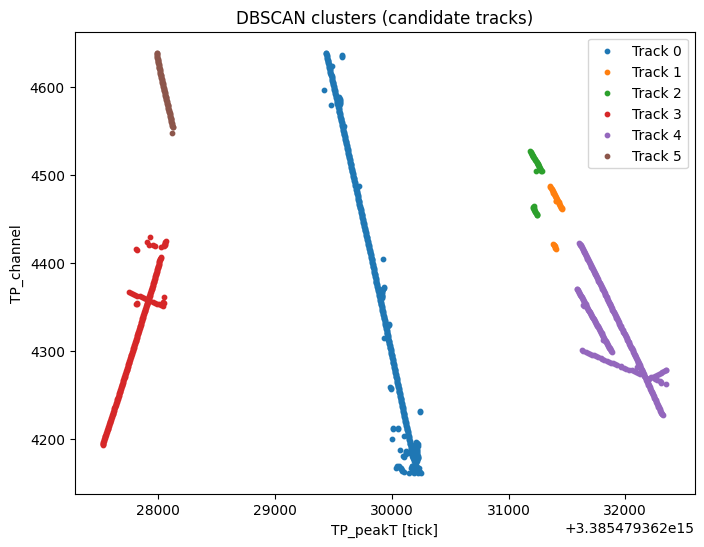

Silhouette -0.33542588052310035


In [116]:
from sklearn.cluster import DBSCAN
from sklearn import metrics
#from filterpy.kalman import KalmanFilter

# Prepare features
X = filtered_APA3[['TP_peakT', 'TP_channel']].values

# DBSCAN clustering
eps = 55 # Tune this!
min_samples = 30
db = DBSCAN(eps=eps, min_samples=min_samples).fit(X) #find the DBSCAN labels: core, border, noise
labels = db.labels_

# Visualize clusters
plt.figure(figsize=(8,6))
for lbl in set(labels):
    if lbl == -1:
        continue  # skip noise
    pts = X[labels == lbl]
    plt.scatter(pts[:,0], pts[:,1], label=f'Track {lbl}', s=10)
plt.xlabel('TP_peakT [tick]')
plt.ylabel('TP_channel')
plt.title('DBSCAN clusters (candidate tracks)')
plt.legend()
plt.show()

print('Silhouette %s' % metrics.silhouette_score(X, db.labels_))

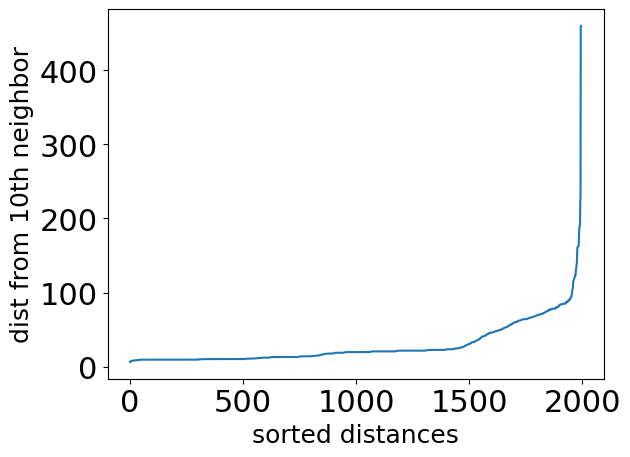

In [84]:
from scipy.spatial.distance import pdist, squareform
dist = pdist(X, 'euclidean') #pair wise distance
dist = squareform(dist) #distance matrix given the vector dist

k = 10
kth_distances = list()
for d in dist:
    index_kth_distance = np.argsort(d)[k]
    kth_distances.append(d[index_kth_distance])

plt.plot(range(0, len(kth_distances)), sorted(kth_distances))
plt.ylabel('dist from %sth neighbor' % k, fontsize=18)
plt.xlabel('sorted distances', fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=22)
plt.show()

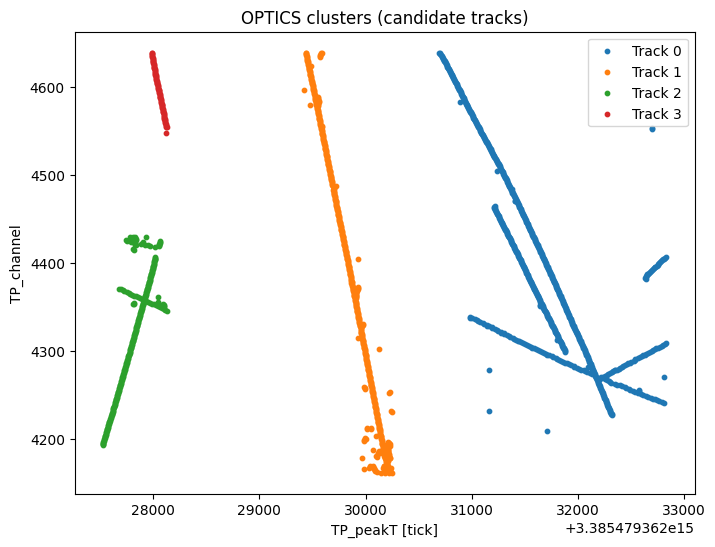

Silhouette -0.13385067040894735


In [123]:
from sklearn.cluster import OPTICS
from sklearn import metrics
import matplotlib.pyplot as plt

# Prepare features
X = filtered_APA3[['TP_peakT', 'TP_channel']].values

# OPTICS clustering
min_samples = 30
xi = 0.05  # Minimum steepness on the reachability plot that constitutes a cluster boundary
min_cluster_size = 70  # Use min_samples as minimum cluster size

optics = OPTICS(min_samples=min_samples, xi=xi, min_cluster_size=min_cluster_size)
optics.fit(X)
labels = optics.labels_

# Visualize clusters (skip noise)
plt.figure(figsize=(8,6))
for lbl in set(labels):
    if lbl == -1:
        continue  # skip noise
    pts = X[labels == lbl]
    plt.scatter(pts[:,0], pts[:,1], label=f'Track {lbl}', s=10)
plt.xlabel('TP_peakT [tick]')
plt.ylabel('TP_channel')
plt.title('OPTICS clusters (candidate tracks)')
plt.legend()
plt.show()

if len(set(labels)) > 1 and len(set(labels)) < len(X):
    print('Silhouette %s' % metrics.silhouette_score(X, labels))
else:
    print("Silhouette score not defined for a single cluster or all noise.")

In [147]:
import numpy as np
from sklearn.linear_model import RANSACRegressor

def find_tracks_ransac_auto(X, residual_threshold=3, min_inliers=20):
    """
    Automatically separates tracks using RANSAC until no good track remains.
    Args:
        X: (N, 2) array with columns [TP_peakT, TP_channel]
        residual_threshold: RANSAC residual threshold for inliers
        min_inliers: Minimum # of inliers to accept a found track
    Returns:
        List of (inlier_points, model) for each found track
    """
    X_remaining = X.copy()
    tracks = []
    while len(X_remaining) >= min_inliers:
        ransac = RANSACRegressor(residual_threshold=residual_threshold)
        try:
            ransac.fit(X_remaining[:,0].reshape(-1,1), X_remaining[:,1])
            inlier_mask = ransac.inlier_mask_
            if np.sum(inlier_mask) < min_inliers:
                break  # Not enough inliers for a valid track
            tracks.append((X_remaining[inlier_mask], ransac))
            X_remaining = X_remaining[~inlier_mask]
        except Exception as e:
            break
    return tracks

# For all clusters:
results = {}
for lbl in set(labels):
    if lbl == -1:
        continue
    cluster_pts = X[labels == lbl]
    tracks = find_tracks_ransac_auto(cluster_pts, residual_threshold=9, min_inliers=30)
    results[lbl] = tracks
    print(f"Cluster {lbl}: Found {len(tracks)} tracks.")

Cluster 0: Found 4 tracks.
Cluster 1: Found 2 tracks.
Cluster 2: Found 2 tracks.
Cluster 3: Found 1 tracks.


### Quantify visible energy

In [ ]:
def quantify_visible_energy_APA(tps, time_window_us=10000, adc_tick_to_mev=0.039):
    """
    Computes the visible energy (sum of TP_SADC × conversion) per time window for each APA.
    Returns a dict {APA_name: (energy_per_window, energy_stats)}
    """
    global apa_ranges

    apa_energy = {}
    for apa, (start, stop) in apa_ranges.itepi {'mean_E_per_window_MeV': 0, 'max_E_per_window_MeV': 0})
            continue
        tmin, tmax = df_apa.TP_peakT.min(), df_apa.TP_peakT.max()
        bins = np.arange(tmin, tmax + time_window_us, time_window_us)
        df_apa = df_apa.copy()
        df_apa["time_bin"] = np.digitize(df_apa.TP_peakT, bins) - 1
        energy_per_bin = df_apa.groupby('time_bin')['TP_SADC'].sum().reindex(range(len(bins)-1), fill_value=0)
        energy_per_bin_MeV = energy_per_bin.values * adc_tick_to_mev
        energy_stats = {
            'mean_E_per_window_MeV': np.mean(energy_per_bin_MeV),
            'max_E_per_window_MeV': np.max(energy_per_bin_MeV)
        }
        apa_energy[apa] = (energy_per_bin_MeV, energy_stats)
    return apa_energy


def plot_visible_energy_per_APA(apa_energy, bins=80, title_suffix=""):
    for apa, (energy_per_window, _) in apa_energy.items():
        if len(energy_per_window) == 0:
            continue
        # Rimuove outlier estremi per la visualizzazione
        max_plot_energy = np.quantile(energy_per_window, 0.999)
        plot_energies = energy_per_window[energy_per_window <= max_plot_energy]

        plt.figure(figsize=(10, 6))
        plt.hist(plot_energies, bins=bins, color='gray', alpha=0.7, edgecolor='black', label="Vis. energy per window")
        # Evidenzia le zone
        plt.axvspan(0, 5, color='blue', alpha=0.12, label='Below 5 MeV')
        plt.axvspan(5, 20, color='orange', alpha=0.15, label='5-20 MeV')
        plt.axvspan(20, plot_energies.max()+1, color='red', alpha=0.10, label='Above 20 MeV')
        plt.xlabel("Visible energy per window [MeV]", fontsize=14)
        plt.ylabel("Number of windows", fontsize=14)
        plt.title(f"{apa} - Visible energy per window {title_suffix}", fontsize=16)
        plt.legend(fontsize=12)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()